# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
book_cost

,Book Cost
Ticker,
BTCUSDT,69141.710000
TRXUSDT,0.164146
JASMYUSDT,0.035478
SOLUSDT,146.170000
OMUSDT,1.150000
ETHUSDT,3810.480000
BBUSDT,0.398000
BNBUSDT,674.930000
PEPEUSDT,0.000002


In [8]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [9]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [10]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))

realized_loss=63.514078
pnl.loc['Loss']=0
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,580.7553,0.2850,-31.2028
TRXUSDT,79.6748,75.9633,0.0373,-3.7115
JASMYUSDT,453.8661,301.1449,0.1478,-152.7212
SOLUSDT,261.7091,283.5525,0.1391,21.8434
OMUSDT,535.6761,568.2359,0.2788,32.5598
ETHUSDT,264.2048,184.1005,0.0903,-80.1043
BBUSDT,46.3321,43.2588,0.0212,-3.0733
BNBUSDT,1.1490,1.0138,0.0005,-0.1352
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [11]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [12]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [13]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [14]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [15]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [16]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDTRXUSDT not retrieved
LDTRXUSDT


In [17]:
positions=positions.sort_index()

In [18]:
positions.index=pd.to_datetime(positions.index)

In [19]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [20]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [21]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [22]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [23]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [24]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [25]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [26]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [27]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

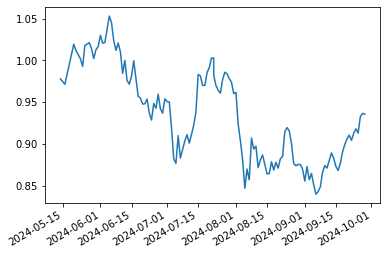

In [28]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [29]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [30]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-15:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [31]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [32]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9339
OMUSDT,0.0233
BNBUSDT,0.0182
TRXUSDT,0.0155
PEPEUSDT,0.0062
JASMYUSDT,0.0021
CKBUSDT,0.0009
STXUSDT,0.0000
SEIUSDT,0.0000
ARUSDT,0.0000


In [34]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.446899
BTCUSDT,0.400000
PEPEUSDT,0.089735
BNBUSDT,0.053322
JASMYUSDT,0.010045


In [35]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [36]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.812985
OMUSDT,0.087304
PEPEUSDT,0.082020
BTCUSDT,0.017691


## Real Portfolio vs Optimal

In [37]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,580.755259,0.284960,0.017691,0.267269
OMUSDT,568.235901,0.278817,0.087304,0.191513
JASMYUSDT,301.144909,0.147763,0.000000,0.000000
SOLUSDT,283.552474,0.139131,0.000000,0.000000
ETHUSDT,184.100490,0.090333,0.000000,0.000000
TRXUSDT,75.963277,0.037273,0.812985,-0.775712
BBUSDT,43.258772,0.021226,0.000000,0.000000
BNBUSDT,1.013821,0.000498,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.082020,-0.082020


In [38]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,580.755259,0.284960,0.400000,-0.115040
OMUSDT,568.235901,0.278817,0.446899,-0.168082
JASMYUSDT,301.144909,0.147763,0.010045,0.137718
SOLUSDT,283.552474,0.139131,0.000000,0.000000
ETHUSDT,184.100490,0.090333,0.000000,0.000000
TRXUSDT,75.963277,0.037273,0.000000,0.000000
BBUSDT,43.258772,0.021226,0.000000,0.000000
BNBUSDT,1.013821,0.000498,0.053322,-0.052825
PEPEUSDT,0.000003,0.000000,0.089735,-0.089735


# Risk Reward Analysis

In [39]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [40]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

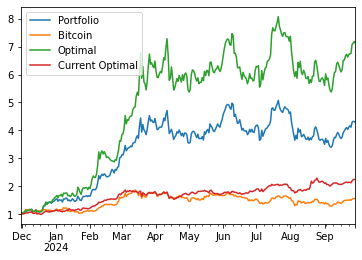

In [41]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [42]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

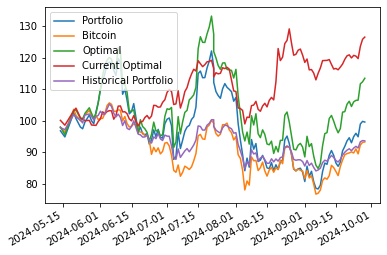

In [43]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [44]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-19,91.844879,89.203528,102.860380,119.456041,89.983209
2024-09-20,93.570719,89.561420,105.208837,120.571197,90.649751
2024-09-21,94.591121,89.770777,106.164759,120.881439,91.097867
2024-09-22,92.999258,90.095833,104.505714,119.907722,90.480102
2024-09-23,94.933946,89.756842,105.977318,120.714567,91.298984
2024-09-24,95.996577,91.054949,106.445178,120.485613,91.853987
2024-09-25,94.900409,89.467434,106.515238,119.703061,91.339446
2024-09-26,98.952226,92.287070,111.700503,123.559031,93.306318
2024-09-27,99.774647,93.127121,112.326050,125.824584,93.693252
2024-09-28,99.570023,93.251712,113.459147,126.513556,93.595109


## Volatilities

In [45]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.707011
dtype: float64

In [46]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.31874
dtype: float64

In [47]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.596208
Bitcoin            0.440732
Optimal            0.708144
Current Optimal    0.339550
dtype: float64

In [48]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.16879759387185475

## Risk Contribution

In [49]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.067504,0.053322,0.011529,0.016656,0.001363,0.015293
BTCUSDT,0.219259,0.400000,0.059090,0.164893,0.061976,0.102917
JASMYUSDT,0.014620,0.010045,0.002354,0.005800,0.000236,0.005564
OMUSDT,8.910117,0.446899,0.892857,0.730287,0.627807,0.102479
PEPEUSDT,0.268353,0.089735,0.034169,0.082364,0.026650,0.055714


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.001620,0.017691,0.017644,0.017645,0.000813,0.016832
OMUSDT,0.008957,0.087304,0.087951,0.102864,0.087123,0.015742
TRXUSDT,0.049653,0.812985,0.788164,0.540941,0.430226,0.110715
PEPEUSDT,0.034260,0.082020,0.106241,0.338549,0.175824,0.162725


In [51]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.025643,0.28,0.275795,0.174546,0.052080,0.122466
OMUSDT,0.028727,0.28,0.278577,0.334854,0.229174,0.105680
JASMYUSDT,0.020478,0.15,0.153829,0.208709,0.070847,0.137862
SOLUSDT,0.020588,0.14,0.144906,0.157429,0.046721,0.110707
ETHUSDT,0.008429,0.09,0.088816,0.082670,0.011207,0.071463
TRXUSDT,0.002443,0.04,0.038298,0.004629,0.000266,0.004363
BBUSDT,0.001919,0.02,0.019778,0.037164,0.002806,0.034358


# Value At Risk

## Historical

In [52]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.059919272242224306, -0.08317241299864703)

In [53]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.01987198270204466, -0.02697255576842509)

In [54]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [55]:
var=historical_var.iloc[row]
var

BTCUSDT      0.001014
OMUSDT      -0.007757
JASMYUSDT   -0.003347
SOLUSDT     -0.004552
ETHUSDT     -0.001088
TRXUSDT     -0.000079
BBUSDT      -0.001019
BNBUSDT      0.000000
PEPEUSDT    -0.000000
Portfolio   -0.016829
Name: 2024-09-22 00:00:00, dtype: float64

In [56]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.001517
OMUSDT      -0.007027
JASMYUSDT   -0.004656
SOLUSDT     -0.005285
ETHUSDT     -0.002478
TRXUSDT      0.000163
BBUSDT      -0.001101
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.021901
dtype: float64

## Parametric

In [57]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0733751178784374, -0.09404661402362899)

In [58]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.03302660097984163, -0.04233097110670998)

## Multivariate

In [59]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06541106732850556, -0.08438288931379101)

In [60]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0258267000705222, -0.03419999733691772)

In [61]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.004001
OMUSDT      -0.008635
JASMYUSDT   -0.005849
SOLUSDT     -0.003721
ETHUSDT     -0.002325
TRXUSDT      0.000014
BBUSDT      -0.001219
Portfolio   -0.025736
dtype: float64

## Copulas

### Gaussian Copula

In [62]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06652373900264849, -0.08548776602595078)

In [63]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.02591340401466098, -0.034065391489899906)

In [64]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.003826
OMUSDT      -0.009288
JASMYUSDT   -0.005463
SOLUSDT     -0.004109
ETHUSDT     -0.001999
TRXUSDT     -0.000029
BBUSDT      -0.001082
Portfolio   -0.025796
dtype: float64

### Student Copula

In [65]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06681049163108818, -0.08559130549110508)

In [66]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.02634792223742165, -0.03521533090974878)

In [67]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.004014
OMUSDT      -0.009804
JASMYUSDT   -0.005345
SOLUSDT     -0.004159
ETHUSDT     -0.002049
TRXUSDT      0.000006
BBUSDT      -0.001005
Portfolio   -0.026370
dtype: float64

### Gumbel Copula

In [68]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12909778233764305, -0.18042047551478924)

In [69]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03840636821875963, -0.0543390800470165)

In [70]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.003677
OMUSDT      -0.024082
JASMYUSDT   -0.007368
SOLUSDT     -0.002234
ETHUSDT     -0.000716
TRXUSDT      0.000153
BBUSDT       0.000081
Portfolio   -0.037843
dtype: float64

### Monte Carlo

In [71]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [72]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07534732454039754, -0.0939943959550625)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.033418533325470165, -0.04170030362320076)

In [74]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.005548
OMUSDT      -0.011415
JASMYUSDT   -0.007159
SOLUSDT     -0.005073
ETHUSDT     -0.002773
TRXUSDT     -0.000164
BBUSDT      -0.001302
Portfolio   -0.033434
dtype: float64

## VaR Violation

In [75]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.059702,-0.103300,-0.089188,-0.025166
2024-01-15,-0.059702,-0.103304,-0.088939,0.017316
2024-01-16,-0.059702,-0.103831,-0.086184,0.057216
2024-01-17,-0.059702,-0.106103,-0.089787,-0.034395
2024-01-18,-0.059702,-0.108146,-0.091348,-0.034217
...,...,...,...,...
2024-09-25,-0.045134,-0.070685,-0.068718,0.000658
2024-09-26,-0.040226,-0.069560,-0.061849,0.048681
2024-09-27,-0.040226,-0.069429,-0.062151,0.005600
2024-09-28,-0.040226,-0.069325,-0.063445,0.010088


In [76]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031638,-0.085290,-0.078768,-0.017777
2024-05-29,-0.028927,-0.082375,-0.071882,-0.010068
2024-05-30,-0.028927,-0.071479,-0.064792,0.038500
2024-05-31,-0.028927,-0.070601,-0.062273,0.028058
2024-06-01,-0.028927,-0.071935,-0.063764,0.041604
...,...,...,...,...
2024-09-25,-0.025571,-0.046479,-0.039645,-0.011419
2024-09-26,-0.025571,-0.050672,-0.041202,0.042695
2024-09-27,-0.025571,-0.048305,-0.040466,0.008311
2024-09-28,-0.025571,-0.048272,-0.040527,-0.002051


<AxesSubplot:>

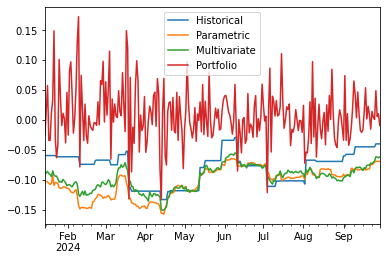

In [77]:
var_data.plot()

<AxesSubplot:>

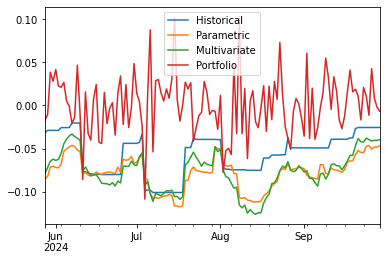

In [78]:
current_var_data.plot()

In [79]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.023077,0.011538,0.011538
Kupiec Stat,4.918254,11.60148,11.60148
P-value,0.026574,0.000659,0.000659


In [80]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.056,0.024,0.024
Kupiec Stat,0.091348,2.184332,2.184332
P-value,0.76247,0.139422,0.139422


## Principal Component Analysis

### Historical PCA

In [81]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78709762, 0.06694082, 0.05480132, 0.04649811, 0.04466213])

In [82]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014358
ADAUSDT     0.014686
ALGOUSDT    0.016235
APTUSDT     0.015641
ARBUSDT     0.015855
              ...   
WBTCUSDT    0.010223
WLDUSDT     0.021943
XLMUSDT     0.009773
XRPUSDT     0.009326
XTZUSDT     0.014768
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

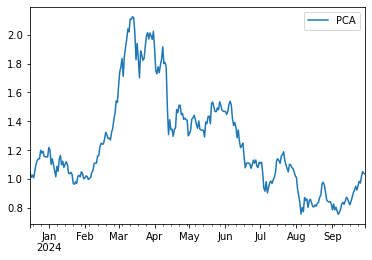

In [83]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

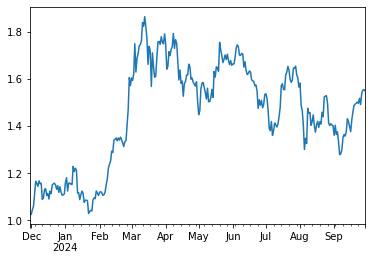

In [84]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [85]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.337536
ADAUSDT      0.341445
ALGOUSDT     0.347772
WBETHUSDT    0.354114
               ...   
PEPEUSDT     1.000706
FLOKIUSDT    1.009512
WLDUSDT      1.045433
CKBUSDT      1.153332
OMUSDT       1.314705
Length: 64, dtype: float64

<AxesSubplot:>

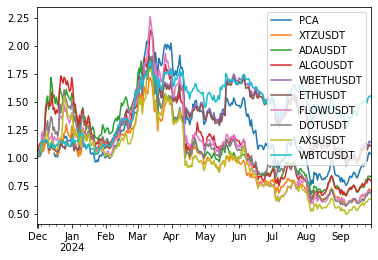

In [86]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

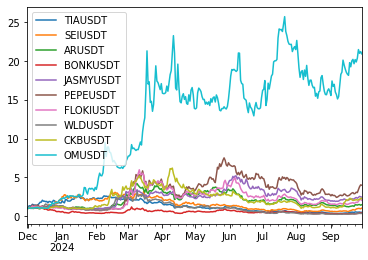

In [87]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [88]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61243012, 0.19373828, 0.0920292 , 0.06309371, 0.03870869])

In [89]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.060424
OMUSDT       0.078654
JASMYUSDT    0.147835
SOLUSDT      0.120472
ETHUSDT      0.094348
TRXUSDT      0.018088
BBUSDT       0.204174
BNBUSDT      0.063159
PEPEUSDT     0.212847
Name: PC1, dtype: float64

<AxesSubplot:>

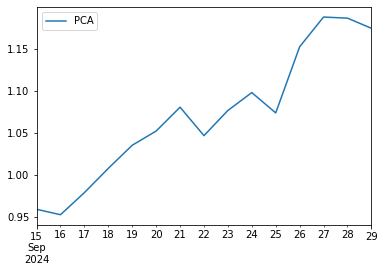

In [90]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

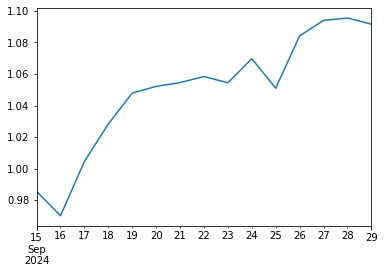

In [91]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [92]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.067865
JASMYUSDT    0.072352
SOLUSDT      0.074234
BTCUSDT      0.079457
BNBUSDT      0.089833
TRXUSDT      0.104984
OMUSDT       0.125831
PEPEUSDT     0.130052
BBUSDT       0.133006
dtype: float64

<AxesSubplot:>

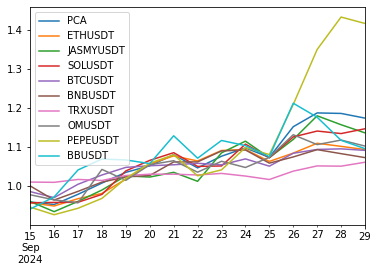

In [93]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [94]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.944767
BBUSDT       1.664799
JASMYUSDT    1.283761
SOLUSDT      1.166493
BTCUSDT      1.000000
OMUSDT       0.986825
ETHUSDT      0.954750
BNBUSDT      0.671666
TRXUSDT      0.280490
Name: BTCUSDT, dtype: float64

In [95]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.909318
BBUSDT       1.766508
JASMYUSDT    1.397154
SOLUSDT      1.182958
BTCUSDT      1.000000
ETHUSDT      0.904747
BNBUSDT      0.797596
OMUSDT       0.566377
TRXUSDT      0.197096
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [96]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.0,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.000000,0.625881,0.150844,0.000000,0.0,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.000000,0.182521,0.000000,0.000000,0.0,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.414537,0.133222,0.000000,0.111977,0.0,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.0,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.000000,0.435173,0.000000,0.000000,0.0,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.287486,0.000000,0.000000,0.0,0.000000,0.712514,0.000000,0.000000


In [97]:
test=pd.read_excel('Trade History.xlsx')
test['Date(UTC)']=pd.to_datetime(test['Date(UTC)'])
test['Time']=test['Date(UTC)'].dt.round('T')
test=test.set_index('Date(UTC)')

In [98]:
trade_info=zip(test['Market'],test.index)
trade_info=dict(enumerate(trade_info))

In [99]:
trade_price={}
for index in trade_info:
    
    if trade_info[index][0][-4:]=='USDT':
        ticker=trade_info[index][0]
    else:
        ticker=trade_info[index][0][-3:]+'USDT'
        
    price=Binance.binance_api.klines(ticker,interval='1m',startTime=int(trade_info[index][1].round(freq='min').timestamp()-60)*1000,limit=1)
        
    trade_price[index]=(trade_info[index][1],trade_info[index][0],price[0][4])

In [105]:
price=pd.DataFrame(trade_price.values(),columns=['Time','Market','Pair Price'])
price=pd.concat([test.reset_index(),price['Pair Price']],axis=1)
price['Price in USDT']=np.where(price['Market'].str[-4:]=='USDT',price['Price'],price['Price'].astype(float)*price['Pair Price'].astype(float))
price['Total in USDT']=price['Price in USDT']*price['Amount'].astype(float)
price